Epoch    1/2000 - loss: 1.1018 - acc: 0.3160
Epoch  100/2000 - loss: 0.0265 - acc: 0.9960
Epoch  200/2000 - loss: 0.0308 - acc: 0.9900
Epoch  300/2000 - loss: 0.0275 - acc: 0.9940
Epoch  400/2000 - loss: 0.0314 - acc: 0.9920
Epoch  500/2000 - loss: 0.0292 - acc: 0.9920
Epoch  600/2000 - loss: 0.0256 - acc: 0.9900
Epoch  700/2000 - loss: 0.0282 - acc: 0.9920
Epoch  800/2000 - loss: 0.0313 - acc: 0.9920
Epoch  900/2000 - loss: 0.0282 - acc: 0.9940
Epoch 1000/2000 - loss: 0.0277 - acc: 0.9940
Epoch 1100/2000 - loss: 0.0248 - acc: 0.9920
Epoch 1200/2000 - loss: 0.0292 - acc: 0.9940
Epoch 1300/2000 - loss: 0.0257 - acc: 0.9940
Epoch 1400/2000 - loss: 0.0263 - acc: 0.9940
Epoch 1500/2000 - loss: 0.0304 - acc: 0.9900
Epoch 1600/2000 - loss: 0.0271 - acc: 0.9940
Epoch 1700/2000 - loss: 0.0285 - acc: 0.9920
Epoch 1800/2000 - loss: 0.0290 - acc: 0.9900
Epoch 1900/2000 - loss: 0.0267 - acc: 0.9940
Epoch 2000/2000 - loss: 0.0269 - acc: 0.9960

Final training accuracy: 0.9960


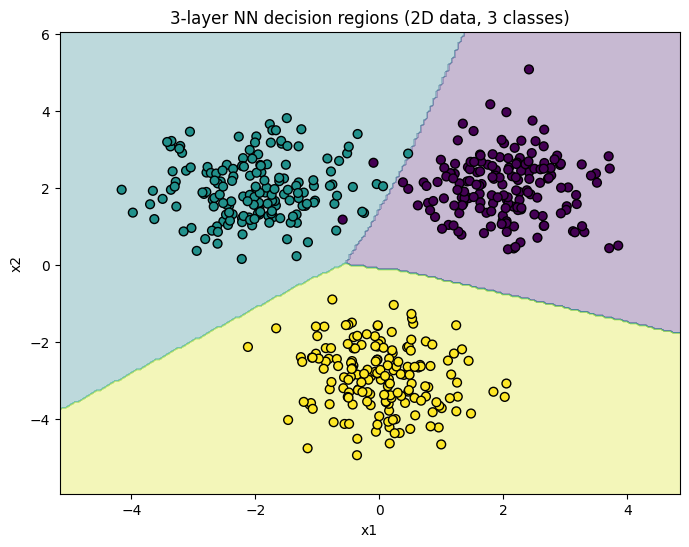

In [3]:


import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

N = 500
D = 2        # input dimensionality (2 so we can plot)
C = 3        # number of classes

# Create three Gaussian blobs as class centers
means = np.array([[2, 2], [-2, 2], [0, -3]])
std = 0.8

X = np.zeros((N, D))
y = np.zeros(N, dtype=int)

points_per_class = N // C
for class_idx in range(C):
    start = class_idx * points_per_class
    end = start + points_per_class
    if class_idx == C - 1:
        # last class takes remaining points
        end = N
    X[start:end] = means[class_idx] + std * np.random.randn(end - start, D)
    y[start:end] = class_idx

# Shuffle dataset
perm = np.random.permutation(N)
X = X[perm]
y = y[perm]

# One-hot encoded labels for loss/grad calculations
Y_onehot = np.eye(C)[y]


H1 = 16
H2 = 8

# Weight initialization (small random values)
W1 = 0.01 * np.random.randn(D, H1)
b1 = np.zeros(H1)

W2 = 0.01 * np.random.randn(H1, H2)
b2 = np.zeros(H2)

W3 = 0.01 * np.random.randn(H2, C)
b3 = np.zeros(C)

# Hyperparameters
learning_rate = 1.0
reg = 1e-3       # L2 regularization strength
num_epochs = 2000
batch_size = 64

# Utilities
def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    return (x > 0).astype(float)

def softmax(z):
    # z: (N, C)
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z_shift)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Training loop (mini-batch SGD)
num_batches = int(np.ceil(N / batch_size))

for epoch in range(1, num_epochs + 1):
    # Shuffle at each epoch
    perm = np.random.permutation(N)
    X_shuffled = X[perm]
    Y_shuffled = Y_onehot[perm]
    y_shuffled = y[perm]

    epoch_loss = 0.0
    epoch_acc = 0.0

    for b in range(num_batches):
        start = b * batch_size
        end = min((b + 1) * batch_size, N)
        xb = X_shuffled[start:end]
        yb = y_shuffled[start:end]
        Yb = Y_shuffled[start:end]

        # Forward pass
        z1 = xb.dot(W1) + b1            # (batch, H1)
        a1 = relu(z1)

        z2 = a1.dot(W2) + b2           # (batch, H2)
        a2 = relu(z2)

        scores = a2.dot(W3) + b3       # (batch, C)
        probs = softmax(scores)

        # Loss: average cross-entropy + L2 regularization
        core_loss = -np.sum(Yb * np.log(probs + 1e-12)) / xb.shape[0]
        reg_loss = 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2) + np.sum(W3 * W3))
        loss = core_loss + reg_loss
        epoch_loss += loss * xb.shape[0]

        preds = np.argmax(probs, axis=1)
        acc = np.mean(preds == yb)
        epoch_acc += acc * xb.shape[0]

        # Backpropagation
        # dL/dscores
        dscores = (probs - Yb) / xb.shape[0]   # (batch, C)

        # Gradients for W3, b3
        dW3 = a2.T.dot(dscores) + reg * W3    # (H2, C)
        db3 = np.sum(dscores, axis=0)

        # Backprop into a2
        da2 = dscores.dot(W3.T)               # (batch, H2)
        dz2 = da2 * relu_grad(z2)             # (batch, H2)

        # Gradients for W2, b2
        dW2 = a1.T.dot(dz2) + reg * W2        # (H1, H2)
        db2 = np.sum(dz2, axis=0)

        # Backprop into a1
        da1 = dz2.dot(W2.T)                   # (batch, H1)
        dz1 = da1 * relu_grad(z1)             # (batch, H1)

        # Gradients for W1, b1
        dW1 = xb.T.dot(dz1) + reg * W1        # (D, H1)
        db1 = np.sum(dz1, axis=0)

        # Parameter update (SGD)
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W3 -= learning_rate * dW3
        b3 -= learning_rate * db3

    epoch_loss /= N
    epoch_acc /= N

    # Print progress
    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}/{num_epochs} - loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f}")

# Final evaluation on training set

# Forward once on full set
z1 = X.dot(W1) + b1
a1 = relu(z1)

z2 = a1.dot(W2) + b2
a2 = relu(z2)

scores = a2.dot(W3) + b3
probs = softmax(scores)
preds = np.argmax(probs, axis=1)
train_acc = np.mean(preds == y)
print(f"\nFinal training accuracy: {train_acc:.4f}")

# ---------------------------
# Plotting data and decision boundary
# ---------------------------

h = 0.05  # grid step size
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# forward on grid
z1g = grid.dot(W1) + b1
a1g = relu(z1g)

z2g = a1g.dot(W2) + b2
a2g = relu(z2g)

scoreg = a2g.dot(W3) + b3
probg = softmax(scoreg)
predg = np.argmax(probg, axis=1)

Z = predg.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=40)
plt.title('3-layer NN decision regions (2D data, 3 classes)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
